# Aumento de data

Se hará uso de Tensorflow y el arreglo de estilo "n-gram" para crear nuevas cadenas de texto a partir del entrenamiento
y predicción de un modelo que permita generar una palabra a partir de sus anteriores.

Fuente: https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

In [1]:
# Importar librerías necesarias. 

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import random
import numpy as np
from random import randrange, choice
import pickle
import nltk 
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
# Carga de la data

NotFlagged_basic = pickle.load(open("./data_final/NotFlagged_basic.p", "rb" ))

In [3]:
#Se carga el tokenizador de la librería Keras y se entrena con el corpus 
# para generar un diccionario de cada una de las palabras con su respectiva representación numérica.

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(NotFlagged_basic)
word_index = tokenizer.word_index

total_words = len(word_index) + 1 

print(tokenizer.word_index)
print(" \n Cantidad de palabras diferentes:",  total_words)

{'i': 1, 'be': 2, 'to': 3, 'and': 4, 'a': 5, 'have': 6, 'help': 7, 'they': 8, 'the': 9, 'it': 10, 'of': 11, 'talk': 12, 'not': 13, 'my': 14, 'she': 15, 'he': 16, 'that': 17, 'listen': 18, 'for': 19, 'know': 20, 'do': 21, 'go': 22, 'someone': 23, 'about': 24, 'as': 25, 'lot': 26, 'think': 27, 'with': 28, 'through': 29, 'really': 30, 'feel': 31, 'always': 32, 'try': 33, 'come': 34, 'would': 35, 'just': 36, 'problem': 37, 'need': 38, 'well': 39, 'in': 40, 'life': 41, 'helped': 42, 'can': 43, 'one': 44, 'some': 45, 'up': 46, 'open': 47, 'sometimes': 48, 'their': 49, 'so': 50, 'who': 51, 'but': 52, 'you': 53, 'much': 54, 'when': 55, 'school': 56, 'shit': 57, 'advice': 58, 'week': 59, 'let': 60, 'good': 61, 'at': 62, 'even': 63, 'often': 64, 'there': 65, 'stuff': 66, 'time': 67, 'ask': 68, 'if': 69, 'too': 70, 'other': 71, 'issue': 72, 'give': 73, 'want': 74, 'struggle': 75, 'feeling': 76, 'going': 77, 'problems': 78, 'may': 79, 'any': 80, 'therapist': 81, 'call': 82, 'pretty': 83, 'please':

In [4]:
# Creación de las secuencias de entrada de la red neuronal 
## con oraciones del set de datos, las cuales serán convertidas en secuencias de números 
## en un arreglo de estilo n-gram

input_sequences = []

for line in NotFlagged_basic:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# Conocer la longitud máxima para igualar las cadenas a la más larga.

max_sequence_len = max([len(x) for x in input_sequences])

# Completar las cadenas cortas a la más larga con el "padding"
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Separación de objetivo y predictoras según el último término del input_sequences para "Y"" y el resto para "X"
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [5]:
# Creación y compilación del modelo de red neuronal

model = Sequential()
model.add(Embedding(total_words, 240, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(100))
model.add(Dropout(0.4))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 240)           106080    
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 300)           469200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 300)           541200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 221)               22321     
_________________________________________________________________
dense_1 (Dense)              (None, 442)               9

In [7]:
class myCallback(tf.keras.callbacks.Callback):
      
      def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')> 0.85):
                  print("\nReached 85% accuracy so cancelling training!")
                  self.model.stop_training = True

callbacks = myCallback()

In [8]:
history = model.fit(predictors, label, batch_size=10, epochs=200, verbose=1, callbacks=[callbacks])

Epoch 1/200
143/143 [==============================] - 11s 30ms/step - loss: 6.4167 - accuracy: 0.0364
Epoch 2/200
143/143 [==============================] - 5s 32ms/step - loss: 5.7226 - accuracy: 0.0350
Epoch 3/200
143/143 [==============================] - 5s 32ms/step - loss: 5.5512 - accuracy: 0.0406
Epoch 4/200
143/143 [==============================] - 5s 38ms/step - loss: 5.3832 - accuracy: 0.0420
Epoch 5/200
143/143 [==============================] - 6s 44ms/step - loss: 5.3049 - accuracy: 0.0434
Epoch 6/200
143/143 [==============================] - 6s 42ms/step - loss: 5.2111 - accuracy: 0.0441
Epoch 7/200
143/143 [==============================] - 7s 52ms/step - loss: 5.1219 - accuracy: 0.0469
Epoch 8/200
143/143 [==============================] - 7s 46ms/step - loss: 5.0538 - accuracy: 0.0483
Epoch 9/200
143/143 [==============================] - 7s 46ms/step - loss: 4.9830 - accuracy: 0.0545
Epoch 10/200
143/143 [==============================] - 7s 48ms/step - loss: 4.91

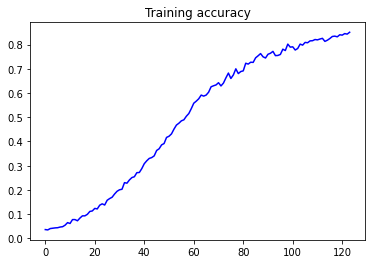

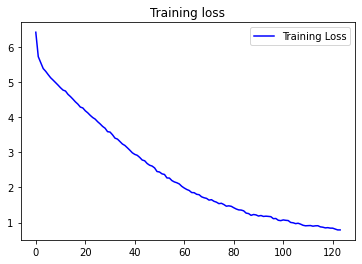

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

#grafica #2
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()

#grafica #1
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [12]:
# Creación de una bolsa de palabras para elegir dos términos de manera aleatoria 
## que permitan dar inicio a las cadenas de texto.

word_list = [key for key in word_index.keys() if key not in stopwords]

# Creación de las variables que nos permitirán escoger al azar un numero 
## según una distribución probabilística normal
mess_range = 500 - len(NotFlagged_basic)
mu, sigma = 8, 1

In [13]:
# Generación de las nuevas cadenas a partir de la secuencia de terminos anterior.

LSTM_temp = []

for _ in range(mess_range):
  text = ""
  text = choice(word_list) # Elección de número aleatorio de longitud
  text = text + ' ' + choice(word_list)
  words_qt =  int(random.gauss(mu, sigma))

  for _ in range(words_qt):
    token_list = tokenizer.texts_to_sequences([text])[0] #conversión del texto inicial en secuencia.
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')  
    predicted = np.argmax(model.predict(token_list), axis=-1) #predicción a partir de la entrada transformada de los tokens
    output_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    text += " " + output_word
  LSTM_temp.append(text)

In [14]:
LSTM_temp[:15]

['live car friends lives well time agony aunt in of',
 'others even truth hurts best way start even would',
 'countless read occurrence kids specifically little esteem book know emotional activity',
 'take letting know someone else irlsomeone experience good',
 'talk bit similar mine necessarily facebook chat went campingsurfing week',
 'offered ok some lot of write to i and able',
 'helped problems go through the same struggle i do',
 'make set path healing personal experience others helping going similar',
 'path talked possibly do not know irlsomeone who do not say',
 'issue blunt sharing side stopped feeling bad the',
 'esteem verge life advice really much calls situation',
 'rejected conflict calm stuff needed wouldnt admit agony aunt something',
 'dumps expressing one schoolwork so think my listener through the',
 'refer ever helpful to ask the car of struggle',
 'stop switch school low life bad stuff talking whos']

In [15]:
pickle.dump(LSTM_temp, open("./data_final/NotFlagged_LSTM.p", "wb" ))